# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                          
Sample_067  P26992                                     17.358
Sample_188  Q8NCC3                                     15.929
Sample_186  Q15582                                     19.169
Sample_022  Q9UQM7                                     17.435
Sample_064  A0A087X152;D6RE16;E0CX15;O95185;O95185-2   14.965
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups        
Sample_042  P17931                   16.456
Sample_038  P98172                   15.640
Sample_189  H0Y7T8;P49418;P49418-2   13.332
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.928
            A0A075B6Q5                 11.593
            A0A075B6R2                 12.544
            A0A075B6S5                 12.770
            A0A087WSY4                 12.095
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.755
            Q9UI40;Q9UI40-2            12.334
            Q9UIW2                     12.454
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.875
            Q9UP79                     11.137
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.860,15.050,16.842,19.863,16.138,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.837,19.067,...,15.528,15.576,14.202,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.920,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.812,17.705,17.039,15.646,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.371,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.887,15.345,17.084,18.708,14.249,19.433,11.882,11.147
Sample_207,15.739,16.877,15.469,16.898,14.456,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.928,...,16.012,15.178,13.988,15.050,16.842,19.863,12.928,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.520,19.067,16.188,...,15.528,15.576,13.638,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.565,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.147,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.831,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.878,15.345,17.084,18.708,14.249,19.433,12.479,12.306
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 349.47it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.89it/s]

100%|██████████| 3/3 [00:00<00:00,  3.43it/s]

100%|██████████| 3/3 [00:00<00:00,  3.64it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.00it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.22it/s]

100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.11it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.61it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.03it/s]

100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

100%|██████████| 5/5 [00:01<00:00,  4.02it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.90it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.83it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.72it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.20it/s]

100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.19it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.62it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.17it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.05it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.03it/s]

100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.07it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.35it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.07it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.06it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.94it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.86it/s]

100%|██████████| 8/8 [00:02<00:00,  2.45it/s]

100%|██████████| 8/8 [00:02<00:00,  2.84it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.75it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.01it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.40it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.50it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.51it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.80it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.06it/s]

100%|██████████| 9/9 [00:03<00:00,  3.23it/s]

100%|██████████| 9/9 [00:03<00:00,  2.92it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.15it/s]

 30%|███       | 3/10 [00:00<00:01,  4.14it/s]

 40%|████      | 4/10 [00:01<00:01,  3.58it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.55it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.31it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.29it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.19it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.20it/s]

100%|██████████| 10/10 [00:02<00:00,  3.20it/s]

100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.55it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.44it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.36it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.18it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.25it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.83it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.63it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.42it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.30it/s]

100%|██████████| 11/11 [00:04<00:00,  2.38it/s]

100%|██████████| 11/11 [00:04<00:00,  2.73it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.32it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.75it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.31it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.15it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.15it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.28it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.45it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.52it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.55it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.56it/s]

100%|██████████| 12/12 [00:04<00:00,  2.54it/s]

100%|██████████| 12/12 [00:04<00:00,  2.50it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.69it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.49it/s]

 31%|███       | 4/13 [00:01<00:03,  2.29it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.40it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.45it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.44it/s]

 62%|██████▏   | 8/13 [00:03<00:01,  2.57it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.60it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.55it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.61it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.82it/s]

100%|██████████| 13/13 [00:04<00:00,  2.88it/s]

100%|██████████| 13/13 [00:04<00:00,  2.64it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.09it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.54it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.92it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.66it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.47it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.41it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.47it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.60it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.76it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.94it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.92it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.98it/s]

100%|██████████| 14/14 [00:04<00:00,  3.08it/s]

100%|██████████| 14/14 [00:04<00:00,  2.87it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.05it/s]

 20%|██        | 3/15 [00:00<00:03,  3.42it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.82it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.77it/s]

 40%|████      | 6/15 [00:01<00:03,  2.82it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.96it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.02it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.15it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.18it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.94it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.92it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.06it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.17it/s]

100%|██████████| 15/15 [00:04<00:00,  3.00it/s]

100%|██████████| 15/15 [00:04<00:00,  3.05it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.066 0.031          0.756 0.355       0.113   
2             0.005 0.006      0.071 0.025          0.703 0.103       0.616   
3             0.005 0.003      0.057 0.018          0.741 0.099       0.705   
4             0.006 0.006      0.071 0.027          0.807 0.075       0.733   
5             0.006 0.005      0.079 0.027          0.822 0.088       0.756   
6             0.005 0.003      0.054 0.016          0.844 0.080       0.797   
7             0.005 0.004      0.058 0.024          0.844 0.079       0.797   
8             0.005 0.004      0.064 0.024          0.826 0.079       0.785   
9             0.006 0.005      0.073 0.034          0.811 0.083       0.838   
10            0.006 0.005      0.077 0.027          0.810 0.081       0.832   
11            0.005 0.004      0.066 0.024          0.800 0.087       0.832   
12            0.004 0.001      0.062 0.018          0.803 0.079       0.831   
13            0.005 0.003      0.062 0.022          0.790 0.080       0.833   
14            0.007 0.005      0.084 0.033          0.791 0.082       0.832   
15            0.009 0.008      0.090 0.034          0.800 0.080       0.802   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.190 0.128                  0.549 0.041        0.851   
2          0.112   0.648 0.079                  0.708 0.058        0.773   
3          0.131   0.715 0.094                  0.760 0.077        0.857   
4          0.105   0.763 0.070                  0.801 0.056        0.896   
5          0.101   0.783 0.072                  0.816 0.058        0.902   
6          0.091   0.816 0.067                  0.843 0.056        0.907   
7          0.090   0.816 0.067                  0.843 0.056        0.904   
8          0.098   0.801 0.069                  0.831 0.057        0.903   
9          0.096   0.820 0.066                  0.846 0.057        0.917   
10         0.096   0.817 0.065                  0.843 0.056        0.914   
11         0.098   0.811 0.067                  0.838 0.058        0.912   
12         0.097   0.812 0.064                  0.840 0.055        0.911   
13         0.108   0.808 0.080                  0.835 0.068        0.914   
14         0.110   0.808 0.081                  0.835 0.069        0.913   
15         0.100   0.798 0.072                  0.827 0.061        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.824 0.088        210.000 0.000  
2          0.069                  0.717 0.093        210.000 0.000  
3          0.057                  0.819 0.074        210.000 0.000  
4          0.048                  0.877 0.058        210.000 0.000  
5          0.048                  0.887 0.059        210.000 0.000  
6          0.049                  0.895 0.055        210.000 0.000  
7          0.051                  0.893 0.056        210.000 0.000  
8          0.051                  0.893 0.055        210.000 0.000  
9          0.046                  0.913 0.044        210.000 0.000  
10         0.048                  0.909 0.048        210.000 0.000  
11         0.049                  0.905 0.049        210.000 0.000  
12         0.050                  0.906 0.049        210.000 0.000  
13         0.045                  0.904 0.046        210.000 0.000  
14         0.044                  0.903 0.046        210.000 0.000  
15         0.044                  0.909 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 466.55it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.37it/s]

100%|██████████| 3/3 [00:00<00:00,  3.70it/s]

100%|██████████| 3/3 [00:00<00:00,  3.93it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.20it/s]

100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.64it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.12it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.78it/s]

100%|██████████| 5/5 [00:01<00:00,  2.49it/s]

100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.97it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.78it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.94it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.37it/s]

100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.32it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.16it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.73it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.98it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.90it/s]

100%|██████████| 7/7 [00:02<00:00,  2.91it/s]

100%|██████████| 7/7 [00:02<00:00,  3.00it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.51it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.69it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.97it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.48it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.27it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.23it/s]

100%|██████████| 8/8 [00:03<00:00,  2.22it/s]

100%|██████████| 8/8 [00:03<00:00,  2.52it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.19it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.89it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.58it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.52it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.20it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.58it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.48it/s]

100%|██████████| 9/9 [00:03<00:00,  2.46it/s]

100%|██████████| 9/9 [00:03<00:00,  2.89it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.38it/s]

 30%|███       | 3/10 [00:00<00:01,  3.92it/s]

 40%|████      | 4/10 [00:01<00:01,  3.41it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.14it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.00it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.73it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.73it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.60it/s]

100%|██████████| 10/10 [00:03<00:00,  2.51it/s]

100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.79it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.01it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.52it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.14it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.89it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.81it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.60it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.33it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.55it/s]

100%|██████████| 11/11 [00:03<00:00,  2.75it/s]

100%|██████████| 11/11 [00:03<00:00,  2.90it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.43it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.61it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.02it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.89it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.75it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.82it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.74it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.74it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.86it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.58it/s]

100%|██████████| 12/12 [00:04<00:00,  2.56it/s]

100%|██████████| 12/12 [00:04<00:00,  2.80it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.42it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.98it/s]

 31%|███       | 4/13 [00:01<00:02,  3.29it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.86it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.74it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.66it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.62it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.50it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.57it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.50it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.51it/s]

100%|██████████| 13/13 [00:04<00:00,  2.64it/s]

100%|██████████| 13/13 [00:04<00:00,  2.77it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.35it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.78it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.14it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.85it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.68it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.63it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.18it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.29it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.28it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.36it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.39it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.43it/s]

100%|██████████| 14/14 [00:05<00:00,  2.42it/s]

100%|██████████| 14/14 [00:05<00:00,  2.57it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.00it/s]

 20%|██        | 3/15 [00:00<00:03,  3.47it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.82it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.52it/s]

 40%|████      | 6/15 [00:02<00:03,  2.53it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.59it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.45it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.57it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.71it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.62it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.69it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.68it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.68it/s]

100%|██████████| 15/15 [00:05<00:00,  2.72it/s]

100%|██████████| 15/15 [00:05<00:00,  2.72it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.053 0.016          0.010 0.071       0.001   
2             0.005 0.006      0.066 0.031          0.773 0.117       0.631   
3             0.007 0.006      0.075 0.026          0.712 0.114       0.621   
4             0.005 0.004      0.062 0.026          0.699 0.115       0.613   
5             0.004 0.002      0.047 0.015          0.723 0.082       0.701   
6             0.005 0.004      0.056 0.019          0.734 0.088       0.707   
7             0.005 0.004      0.059 0.026          0.726 0.082       0.709   
8             0.004 0.003      0.052 0.018          0.748 0.079       0.740   
9             0.004 0.004      0.051 0.012          0.742 0.079       0.739   
10            0.004 0.000      0.045 0.003          0.789 0.080       0.765   
11            0.002 0.000      0.029 0.005          0.840 0.082       0.801   
12            0.004 0.001      0.046 0.011          0.832 0.087       0.791   
13            0.005 0.003      0.059 0.022          0.830 0.093       0.795   
14            0.006 0.005      0.061 0.020          0.820 0.095       0.788   
15            0.004 0.000      0.048 0.007          0.827 0.083       0.801   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.861   
2          0.126   0.685 0.096                  0.743 0.071        0.788   
3          0.131   0.655 0.102                  0.715 0.078        0.793   
4          0.135   0.645 0.105                  0.707 0.080        0.789   
5          0.109   0.707 0.075                  0.751 0.059        0.863   
6          0.107   0.715 0.077                  0.758 0.061        0.865   
7          0.114   0.711 0.074                  0.755 0.056        0.864   
8          0.110   0.738 0.072                  0.777 0.058        0.868   
9          0.109   0.735 0.071                  0.774 0.058        0.865   
10         0.104   0.772 0.070                  0.806 0.057        0.894   
11         0.102   0.816 0.071                  0.843 0.059        0.908   
12         0.094   0.807 0.071                  0.836 0.060        0.908   
13         0.090   0.808 0.068                  0.836 0.058        0.910   
14         0.090   0.799 0.067                  0.828 0.056        0.908   
15         0.096   0.810 0.067                  0.838 0.055        0.911   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.830 0.088        210.000 0.000  
2          0.076                  0.735 0.095        210.000 0.000  
3          0.072                  0.743 0.094        210.000 0.000  
4          0.076                  0.732 0.096        210.000 0.000  
5          0.054                  0.834 0.062        210.000 0.000  
6          0.054                  0.836 0.066        210.000 0.000  
7          0.054                  0.836 0.064        210.000 0.000  
8          0.057                  0.838 0.067        210.000 0.000  
9          0.057                  0.836 0.068        210.000 0.000  
10         0.049                  0.868 0.063        210.000 0.000  
11         0.045                  0.889 0.053        210.000 0.000  
12         0.045                  0.888 0.052        210.000 0.000  
13         0.044                  0.894 0.050        210.000 0.000  
14         0.044                  0.891 0.051        210.000 0.000  
15         0.042                  0.894 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 907.86it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 33.82it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 14.77it/s]

100%|██████████| 3/3 [00:00<00:00, 13.78it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.94it/s]

100%|██████████| 4/4 [00:00<00:00, 14.54it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.37it/s]

100%|██████████| 5/5 [00:00<00:00, 14.14it/s]

100%|██████████| 5/5 [00:00<00:00, 14.74it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 17.00it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.96it/s]

100%|██████████| 6/6 [00:00<00:00, 13.77it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.65it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 13.83it/s]

100%|██████████| 7/7 [00:00<00:00, 12.34it/s]

100%|██████████| 7/7 [00:00<00:00, 13.15it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 27.72it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 24.28it/s]

100%|██████████| 8/8 [00:00<00:00, 23.53it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 17.70it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 15.50it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 14.17it/s]

100%|██████████| 9/9 [00:00<00:00, 13.27it/s]

100%|██████████| 9/9 [00:00<00:00, 13.99it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 24.93it/s]

 60%|██████    | 6/10 [00:00<00:00, 23.30it/s]

 90%|█████████ | 9/10 [00:00<00:00, 21.53it/s]

100%|██████████| 10/10 [00:00<00:00, 21.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 28.14it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 23.64it/s]

 91%|█████████ | 10/11 [00:00<00:00, 23.08it/s]

100%|██████████| 11/11 [00:00<00:00, 23.12it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 28.67it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 25.02it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 22.96it/s]

100%|██████████| 12/12 [00:00<00:00, 23.61it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 36.19it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 30.99it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 29.25it/s]

100%|██████████| 13/13 [00:00<00:00, 29.92it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 35.52it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 30.54it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 29.20it/s]

100%|██████████| 14/14 [00:00<00:00, 29.62it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 33.75it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 29.49it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 28.79it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 28.44it/s]

100%|██████████| 15/15 [00:00<00:00, 28.96it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.036 0.011          0.000 0.000       0.000   
2             0.004 0.004      0.055 0.032          0.708 0.093       0.574   
3             0.005 0.003      0.058 0.019          0.638 0.089       0.579   
4             0.005 0.004      0.064 0.024          0.645 0.097       0.591   
5             0.004 0.002      0.054 0.015          0.635 0.090       0.587   
6             0.004 0.000      0.047 0.004          0.629 0.085       0.592   
7             0.003 0.001      0.034 0.010          0.629 0.088       0.587   
8             0.003 0.001      0.033 0.007          0.627 0.097       0.571   
9             0.004 0.000      0.042 0.006          0.646 0.087       0.579   
10            0.002 0.000      0.029 0.005          0.636 0.083       0.567   
11            0.003 0.000      0.028 0.002          0.636 0.086       0.558   
12            0.002 0.000      0.027 0.000          0.629 0.084       0.555   
13            0.002 0.000      0.027 0.001          0.679 0.073       0.633   
14            0.002 0.000      0.027 0.000          0.669 0.073       0.627   
15            0.002 0.000      0.027 0.000          0.665 0.074       0.625   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.749   
2          0.125   0.627 0.099                  0.700 0.066        0.774   
3          0.123   0.601 0.095                  0.669 0.070        0.767   
4          0.124   0.609 0.095                  0.675 0.071        0.766   
5          0.126   0.604 0.096                  0.671 0.072        0.765   
6          0.127   0.604 0.093                  0.669 0.071        0.760   
7          0.126   0.602 0.094                  0.667 0.073        0.756   
8          0.115   0.592 0.092                  0.660 0.073        0.759   
9          0.121   0.605 0.095                  0.674 0.069        0.756   
10         0.112   0.595 0.089                  0.665 0.064        0.753   
11         0.115   0.588 0.091                  0.662 0.064        0.751   
12         0.113   0.584 0.090                  0.658 0.064        0.745   
13         0.123   0.650 0.091                  0.709 0.064        0.799   
14         0.127   0.642 0.091                  0.701 0.067        0.796   
15         0.136   0.638 0.099                  0.699 0.070        0.792   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.705 0.075        210.000 0.000  
2          0.067                  0.721 0.080        210.000 0.000  
3          0.068                  0.720 0.074        210.000 0.000  
4          0.067                  0.713 0.072        210.000 0.000  
5          0.066                  0.703 0.075        210.000 0.000  
6          0.066                  0.697 0.076        210.000 0.000  
7          0.066                  0.693 0.076        210.000 0.000  
8          0.065                  0.698 0.074        210.000 0.000  
9          0.065                  0.698 0.076        210.000 0.000  
10         0.063                  0.695 0.075        210.000 0.000  
11         0.063                  0.692 0.074        210.000 0.000  
12         0.064                  0.681 0.076        210.000 0.000  
13         0.060                  0.733 0.074        210.000 0.000  
14         0.061                  0.727 0.073        210.000 0.000  
15         0.060                  0.723 0.070 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,3,4
score_time,15,3,4
test_precision,6,11,2
test_recall,9,15,13
test_f1,9,11,13
test_balanced_accuracy,9,11,13
test_roc_auc,15,15,13
test_average_precision,9,15,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.39it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.24it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.68it/s]

 40%|████      | 6/15 [00:00<00:01,  6.31it/s]

 47%|████▋     | 7/15 [00:01<00:01,  6.04it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  5.94it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.80it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.78it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  5.72it/s]

 80%|████████  | 12/15 [00:01<00:00,  5.75it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.71it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.69it/s]

100%|██████████| 15/15 [00:02<00:00,  5.67it/s]

100%|██████████| 15/15 [00:02<00:00,  6.06it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 38.07it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 31.06it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 29.50it/s]

100%|██████████| 13/13 [00:00<00:00, 29.93it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 12.84it/s]

 27%|██▋       | 4/15 [00:00<00:01,  8.37it/s]

 33%|███▎      | 5/15 [00:00<00:01,  7.65it/s]

 40%|████      | 6/15 [00:00<00:01,  7.39it/s]

 47%|████▋     | 7/15 [00:00<00:01,  7.18it/s]

 53%|█████▎    | 8/15 [00:01<00:00,  7.07it/s]

 60%|██████    | 9/15 [00:01<00:00,  7.00it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.89it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.81it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.78it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  6.78it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  6.67it/s]

100%|██████████| 15/15 [00:02<00:00,  6.69it/s]

100%|██████████| 15/15 [00:02<00:00,  7.14it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


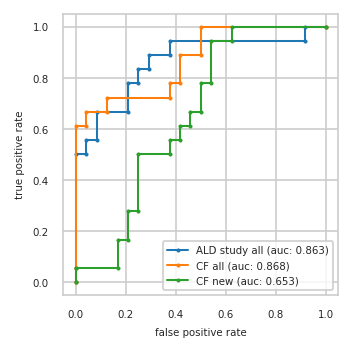

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.500  0.000 0.611  0.167 0.056
3          0.042 0.500  0.042 0.611  0.167 0.167
4          0.042 0.556  0.042 0.667  0.208 0.167
5          0.083 0.556  0.125 0.667  0.208 0.278
6          0.083 0.667  0.125 0.722  0.250 0.278
7          0.208 0.667  0.375 0.722  0.250 0.500
8          0.208 0.778  0.375 0.778  0.375 0.500
9          0.250 0.778  0.417 0.778  0.375 0.556
10         0.250 0.833  0.417 0.889  0.417 0.556
11         0.292 0.833  0.500 0.889  0.417 0.611
12         0.292 0.889  0.500 1.000  0.458 0.611
13         0.375 0.889  1.000 1.000  0.458 0.667
14         0.375 0.944    NaN   NaN  0.500 0.667
15         0.917 0.944    NaN   NaN  0.500 0.778
16         0.917 1.000    NaN   NaN  0.542 0.778
17         1.000 1.000    NaN   NaN  0.542 0.944
18           NaN   NaN    NaN   NaN  0.625 0.944
19           NaN   NaN    NaN   NaN  0.625 1.000
20           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,F6VDH7;P50502;Q3KNR6,Q8NBI6,G3V295;G3V3I1;G3V5Z7;P60900
2,Q92743,A0A1B0GV23;A0A1B0GVD5;A0A1B0GWE8;P07339,P31150
3,P04075,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
4,P61981,Q14894,Q9NUQ9
5,P14174,P14174,P31321
6,A0A0C4DGY8;D6RA00;Q9UHY7,P61981,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
7,P05413;S4R371,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,P08294,P63104,Q96GD0


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


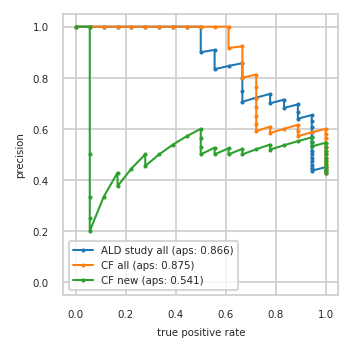

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.436 0.944     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.529 1.000
9          0.515 0.944     0.545 1.000     0.545 1.000
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.548 0.944
12         0.567 0.944     0.600 1.000     0.567 0.944
13         0.586 0.944     0.586 0.944     0.552 0.889
14         0.607 0.944     0.571 0.889     0.536 0.833
15         0.630 0.944     0.593 0.889     0.519 0.778
16         0.654 0.944     0.615 0.889     0.538 0.778
17         0.640 0.889     0.600 0.833     0.520 0.722
18         0.667 0.889     0.583 0.778     0.500 0.667
19         0.696 0.889     0.609 0.778     0.522 0.667
20         0.682 0.833     0.591 0.722     0.500 0.611
21         0.714 0.833     0.619 0.722     0.524 0.611
22         0.700 0.778     0.650 0.722     0.500 0.556
23         0.737 0.778     0.684 0.722     0.526 0.556
24         0.722 0.722     0.722 0.722     0.500 0.500
25         0.706 0.667     0.765 0.722     0.529 0.500
26         0.750 0.667     0.812 0.722     0.562 0.500
27         0.800 0.667     0.800 0.667     0.600 0.500
28         0.857 0.667     0.857 0.667     0.571 0.444
29         0.846 0.611     0.923 0.667     0.538 0.389
30         0.833 0.556     0.917 0.611     0.500 0.333
31         0.909 0.556     1.000 0.611     0.455 0.278
32         0.900 0.500     1.000 0.556     0.500 0.278
33         1.000 0.500     1.000 0.500     0.444 0.222
34         1.000 0.444     1.000 0.444     0.375 0.167
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.333 0.111
37         1.000 0.278     1.000 0.278     0.200 0.056
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


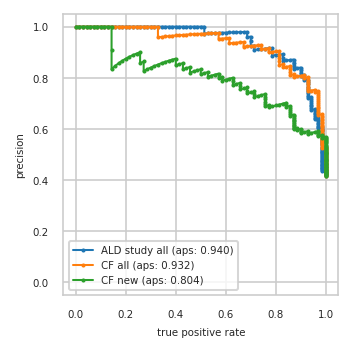

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


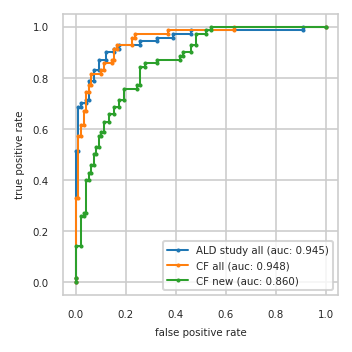

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}